# Preprocessing

In [1]:
import matplotlib.pyplot as plt
textwidth = 15
figheight = 0.25*textwidth
plt.rcParams["figure.figsize"] = (0.66*textwidth,figheight)
plt.rcParams['text.latex.unicode']=True
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('grid', linestyle="--")
plt.rc('grid', alpha="0.5")
plt.rc('axes', grid=True)

import numpy as np
import re

!mkdir fig

def xaxis_mpi():
    #plt.xscale('log',basex=2)
    plt.gca().set_xticks([1,2,4,8,16,32,64])
    plt.xlim([1,64])
    plt.xlabel("Nombre de processus MPI")
    plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

mkdir: cannot create directory ‘fig’: File exists


## Parsing

In [2]:
filename_regex = ".*stdout_collision_p(\d*)_s(\d*)\.1\.(\d*):"
#filename_regex = ".*stdout_collision_p(\d*)_s(\d*)/1/rank.(\d*)/stdout:"

#### Parse timers

In [3]:
!find data/ -name stdout* -exec bash -c "grep 'Timer' {} /dev/null" \; > data/bench_collision_timers.txt

In [4]:
t_last={}
t_total={}
for line in open("data/bench_collision_timers.txt"):
    nb_proc,size,rank,name,t_last_,t_total_ = re.match(filename_regex+"Timer : (\S*)\s*Last :\s*(\d*.\d*) ms   Total :\s*(\d*.\d*) s", line).groups()
    nb_proc = int(nb_proc)
    size = int(size)
    rank = int(rank)
    t_total[nb_proc,size,rank,name] = float(t_last_)/1000.
    
list_nb_procs = sorted([a for a in set([ p for (p,s,r,n) in t_total.keys() ])])
#list_names = sorted([a for a in set([ n for (p,r,n) in t_total.keys() ])])
list_names = [ 'Collision', 'Collision.Prepare', 'Collision.Detect', 'Collision.Handle']
list_ranks = sorted([a for a in set([ r for (p,s,r,n) in t_total.keys() ])])

In [5]:
timers_labels={}
for name in list_names : 
    timers_labels[name] = name.translate(str.maketrans({"_":  r"\_"}) )
timers_labels['Autres']="Autres"
name_total='Collision'

#### Parse counts

In [6]:
!find data/ -name stdout* -exec bash -c "grep -E 'Local sphere count|Ghost spheres count|Local Morton blocks count|Process local detected collisions|Total detected collisions' {} /dev/null" \; > data/bench_collision_counts.txt

In [7]:
counts = {'  Local sphere count ':{}, 
          '  Local Morton blocks count ':{},
          '  Ghost spheres count ':{},
          'Process local detected collisions ':{},
          'Total detected collisions ':{} }
for line in open("data/bench_collision_counts.txt"):
    nb_proc,size,rank,name,count = re.match(filename_regex+"(.*):\s*(\d*).*", line).groups()
    count = int(count)
    nb_proc = int(nb_proc)
    size = int(size)
    rank = int(rank)
    counts[name][nb_proc,size,rank] = count

local_ghosts = counts['  Ghost spheres count ']
local_sp = counts['  Local sphere count ']
local_morton = counts['  Local Morton blocks count ']
local_collision = counts['Process local detected collisions ']
global_collision = counts['Total detected collisions ']

## Plots

### Nombre de sphères

In [8]:
def get_counts( size ):
    sp_max = np.array([ max( [local_sp[p,size(p),r] for r in range(p)] ) for p in list_nb_procs ])
    sp_min = np.array([ min( [local_sp[p,size(p),r] for r in range(p)] ) for p in list_nb_procs ])
    sp_total = np.array([ sum( [local_sp[p,size(p),r] for r in range(p)] ) for p in list_nb_procs ])
    ghost_max = np.array([ max( [local_ghosts[p,size(p),r] for r in range(p)] ) for p in list_nb_procs ])
    ghost_min = np.array([ min( [local_ghosts[p,size(p),r] for r in range(p)] ) for p in list_nb_procs ])
    ghost_total = np.array([ sum( [local_ghosts[p,size(p),r] for r in range(p)] ) for p in list_nb_procs ])
    ghost_prop_max = np.array([ max( [local_ghosts[p,size(p),r]/local_sp[p,size(p),r] for r in range(p)] ) for p in list_nb_procs ])
    ghost_prop_min = np.array([ min( [local_ghosts[p,size(p),r]/local_sp[p,size(p),r] for r in range(p)] ) for p in list_nb_procs ])
    ghost_prop_mean = ghost_total/sp_total
    return sp_min, sp_max, sp_total, ghost_min, ghost_max, ghost_total, ghost_prop_min, ghost_prop_max, ghost_prop_mean
    
def plot_sp_count( sp_min, sp_max, sp_total ):
    plt.plot( list_nb_procs, sp_max, "d-", label='Max' )
    plt.plot( list_nb_procs, sp_total/list_nb_procs, "d-", label='Moyenne' )
    plt.plot( list_nb_procs, sp_min, "d-", label='Min' )
    plt.ylabel("Nombre de sphères par processus MPI")
    plt.ylim(0)
    plt.xscale('log',basex=2)
    xaxis_mpi()

def plot_sp_inbalance( sp_min, sp_max, sp_total ):   
    plt.plot( list_nb_procs, 100*((sp_max*list_nb_procs)-sp_total)/sp_total    , "d-", label='Max' )
    plt.plot( list_nb_procs, 100*((sp_min*list_nb_procs)-sp_total)/sp_total     , "d-", label='Min')
    plt.ylabel("Inbalance : $(N_{local}-N_{moyen})/N_{moyen}$ (\%)")
    plt.xscale('log',basex=2)
    plt.ylim([-1,1])
    xaxis_mpi()

def plot_ghost_count( ghost_min, ghost_max, ghost_total ):
    plt.plot( list_nb_procs, ghost_max, "d-", label='Max' )
    plt.plot( list_nb_procs, ghost_total/list_nb_procs, "d-", label='Moyenne' )
    plt.plot( list_nb_procs, ghost_min, "d-", label='Min' )
    plt.ylabel("Nombre de ghosts par processus MPI")
    plt.ylim(0)
    plt.xscale('log',basex=2)
    xaxis_mpi()

def plot_ghost_percent( ghost_prop_min, ghost_prop_max, ghost_prop_mean ):
    plt.plot( list_nb_procs, 100*ghost_prop_max, "d-", label='Max' )
    plt.plot( list_nb_procs, 100*ghost_prop_mean, "d-", label='Moyenne' )
    plt.plot( list_nb_procs, 100*ghost_prop_min, "d-", label='Min')
    plt.ylabel("Ghosts/Total (\%)")
    plt.xscale('log',basex=2)
    plt.ylim([0,20])
    xaxis_mpi()    
    
def plot_counts(size):
    plt.figure(figsize=(0.66*textwidth, 2*figheight))
    
    sp_min, sp_max, sp_total, ghost_min, ghost_max, ghost_total, ghost_prop_min, ghost_prop_max, ghost_prop_mean = get_counts(size)
    
    plt.subplot(221)
    plot_sp_count( sp_min, sp_max, sp_total )
    plt.title("Nombre de sphères par MPI")
    plt.legend()
    
    plt.subplot(222)
    plot_sp_inbalance( sp_min, sp_max, sp_total )
    plt.title("Load balancing")
    plt.legend()
    
    plt.subplot(223)
    plot_ghost_count( ghost_min, ghost_max, ghost_total )
    plt.title("Nombre de ghosts par MPI")
    plt.legend()
    
    plt.subplot(224)
    plot_ghost_percent( ghost_prop_min, ghost_prop_max, ghost_prop_mean )
    plt.title("Proportion de ghosts")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Temps

In [9]:
def extract_times( size ):
    ts_total_max={}
    ts_total_min={}
    for name in list_names:
        ts_total_max[name] = np.array([ max([ t_total[p,size(p),rank,name] for rank in range(p) ]) for p in list_nb_procs ])
        ts_total_min[name] = np.array([ min([ t_total[p,size(p),rank,name] for rank in range(p) ]) for p in list_nb_procs ])
    return ts_total_min, ts_total_max

In [10]:
def plot_times_multiple( ts_min, ts_max ):
    plt.figure(figsize=(textwidth, 3*figheight))
    i=1
    for name in list_names:
        plt.subplot(3,3,i)
        line, = plt.plot( list_nb_procs, ts_max[name], 'd-', label='Max' )
        plt.plot( list_nb_procs, ts_min[name], 'd--', color=line.get_color(), label='Min' )    
        plt.title( timers_labels[name] ) 
        #plt.xscale('log',basex=2)
        plt.ylim(0)
        plt.ylabel('Temps (s)')
        xaxis_mpi()
        i=i+1  
    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1.5,0.5))
    plt.show()

def plot_times_all( ts_max ):
    names_to_plot = [ 'Collision.Prepare', 'Collision.Detect', 'Collision.Handle']
    plt.figure(figsize=(0.33*textwidth, figheight))
    for name in reversed(names_to_plot):
        line, = plt.plot( list_nb_procs, ts_max[name], 'd-', label=timers_labels[name] )
    #plt.yscale('log')
    plt.ylim(0)
    plt.ylabel('Temps (s)')
    xaxis_mpi()
    plt.legend()
    plt.show()
    
def plot_times_accumulated( ts_max ):  
    plt.figure(figsize=(0.33*textwidth, figheight))
    names_to_plot = [ 'Collision.Prepare', 'Collision.Detect', 'Collision.Handle']
    names_to_plot = sorted(names_to_plot, key=lambda n : ts_max[n][-1])

    times_tot = ts_max[name_total]
    times=[ ts_max[name] for name in names_to_plot ]
    times_rem = times_tot - np.sum( times, axis=0 )
    times = [np.zeros(len(times[0])),times_rem] + times
    times_sum = np.cumsum(times,axis=0)
    labels = [ timers_labels[name] for name in ['Autres'] + names_to_plot ]

    for i in range(len(times_sum)-1,0,-1) :
        plt.fill_between(list_nb_procs, times_sum[i-1], times_sum[i], alpha=0.7, label=labels[i-1])
    plt.plot(list_nb_procs, times_sum[i])

    plt.plot(list_nb_procs,ts_max[name_total], '-d', label='Temps total')

    #plt.yscale('log')
    plt.xscale('log',basex=2)
    plt.grid(linestyle="--", color='black')
    #plt.ylim([0,200])
    plt.ylim(0)
    plt.ylabel('Temps accumulé (s)')
    xaxis_mpi()
    plt.legend()
    plt.show()
    
def plot_times( size )  : 
    ts_min, ts_max = extract_times( size )
    plot_times_multiple( ts_min, ts_max )
    plot_times_accumulated(ts_max)
    plot_times_all(ts_max)

### Efficacité

In [11]:
def t_perfect (ts, size) :
    return np.array([ts[0]*(size(p)/size(1))/p for p in list_nb_procs])

def plot_efficiency_multiple( ts_min, ts_max, size ) :
    plt.figure(figsize=(textwidth, 3*figheight))
    i=1
    for name in list_names:
        plt.subplot(3,3,i)
        plt.title( timers_labels[name] )
        line, = plt.plot( list_nb_procs, 100*t_perfect(ts_max[name],size)/ts_max[name], 'd-', label="Max" )
        plt.plot( list_nb_procs, 100*t_perfect(ts_min[name],size)/ts_min[name], 'd--', color=line.get_color(), label='Min' )
        i=i+1
        plt.ylabel( 'Efficacité (\%)' )
        plt.xscale('log',basex=2)
        xaxis_mpi()
        plt.ylim(0)
    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1.5,0.5))
    plt.show()
    
def plot_efficiency_all( ts_max, size ) :
    plt.figure(figsize=(0.33*textwidth, figheight))
    i=1
    for name in list_names:
        line, = plt.plot( list_nb_procs, 100*t_perfect(ts_max[name],size)/ts_max[name], 'd-', label=timers_labels[name] )
    plt.ylabel( 'Efficacité (\%)' )
    plt.xscale('log',basex=2)
    xaxis_mpi()
    plt.ylim(0)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
def plot_efficiency( size ):
    ts_min, ts_max = extract_times( size )
    plot_efficiency_multiple( ts_min, ts_max , size)
    plot_efficiency_all( ts_max, size )

# Benchmark

## Weak scaling

In [12]:
def weak_scaling_size(p):
    return p

### Nombre de sphères

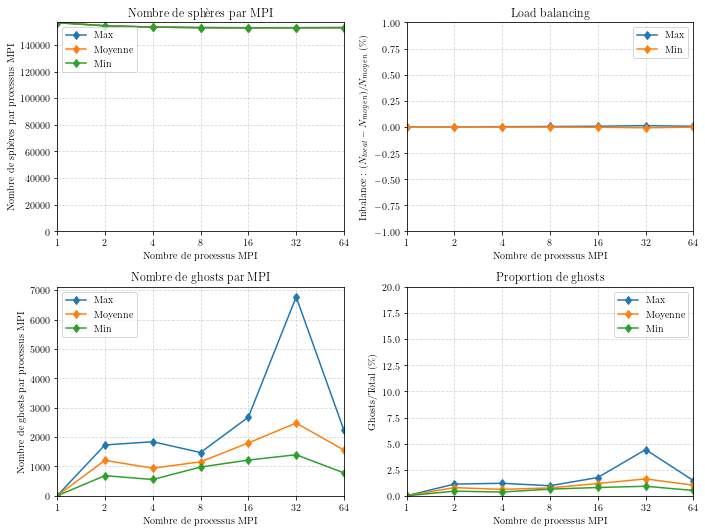

In [13]:
plot_counts( weak_scaling_size )

### Temps

Ce sont les temps d'execution pour 100 itérations de PrismaticGlide 

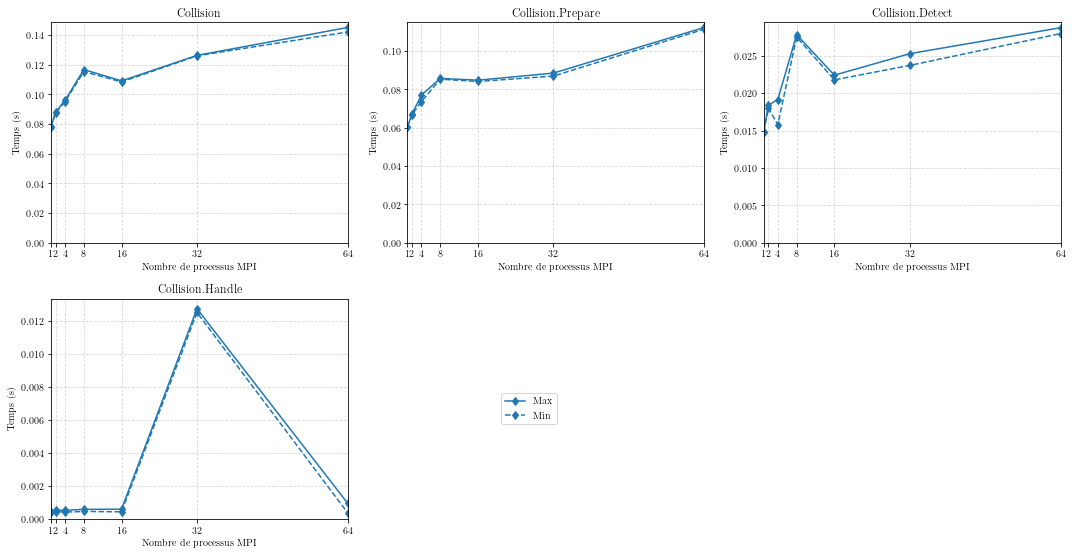

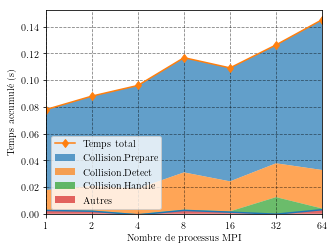

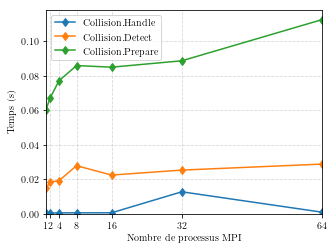

In [14]:
plot_times(weak_scaling_size)

### Efficacité

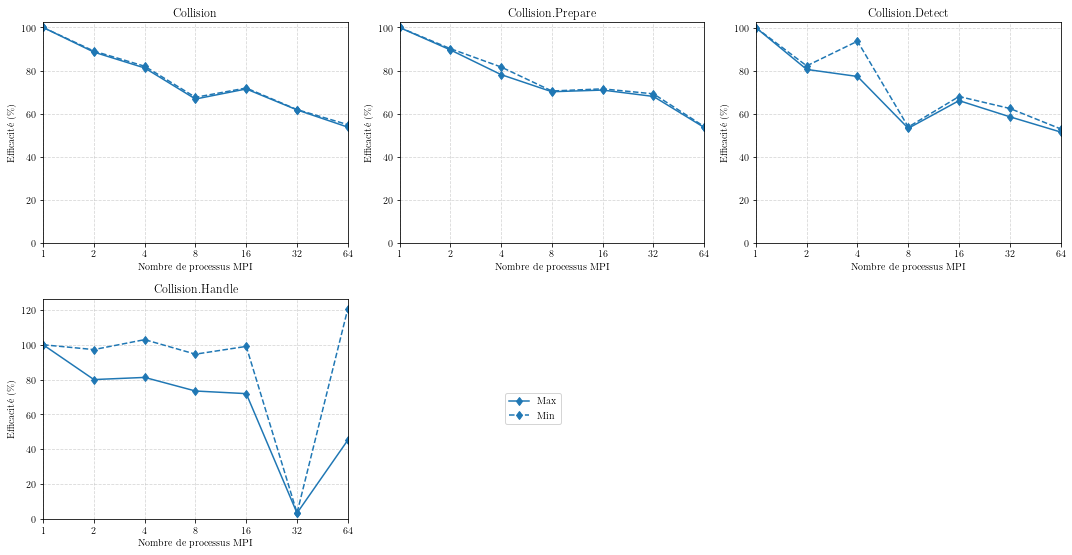

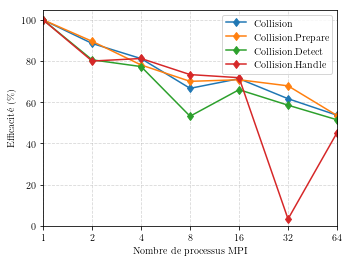

In [15]:
plot_efficiency( weak_scaling_size )

## Strong scaling

In [16]:
def strong_scaling_size(p):
    return 16

### Nombre de sphères

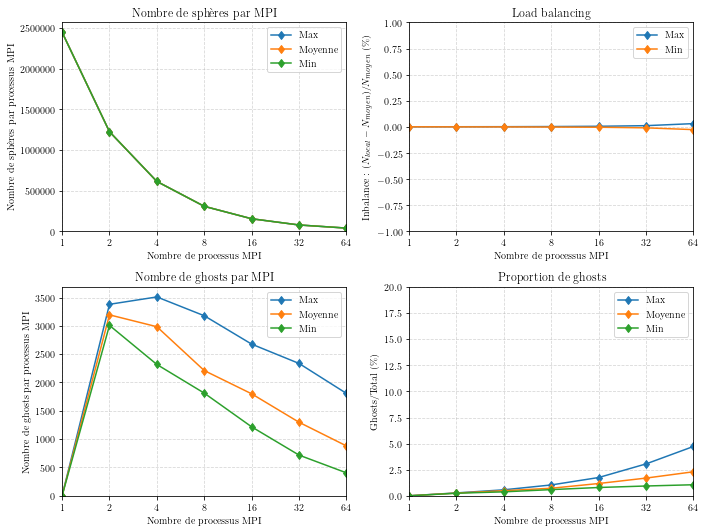

In [17]:
plot_counts( strong_scaling_size )

### Temps

Ce sont les temps d'execution pour 100 itérations de PrismaticGlide 

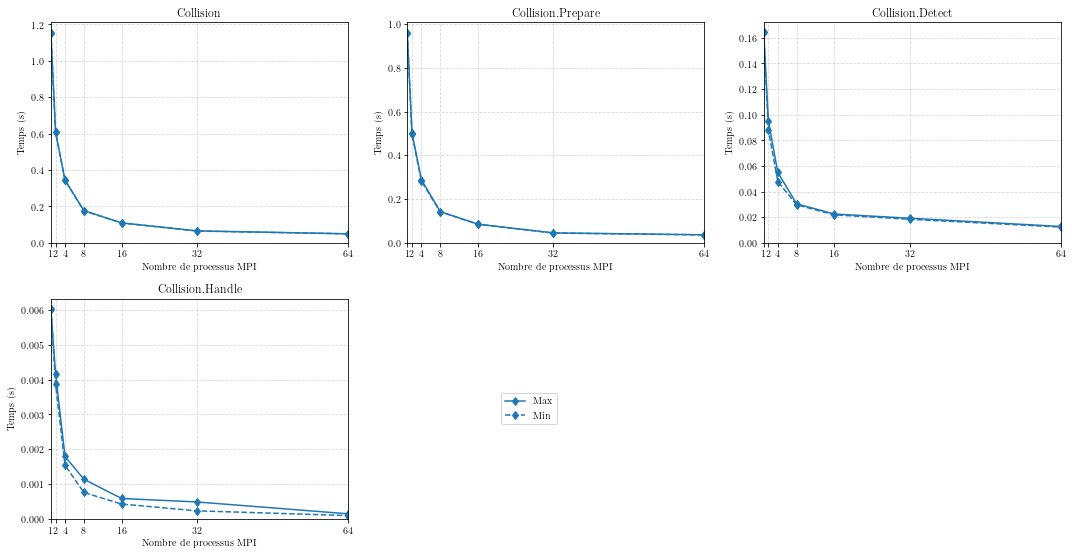

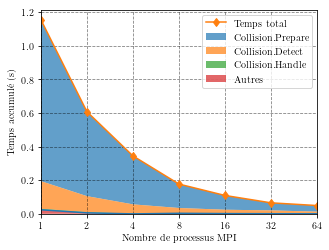

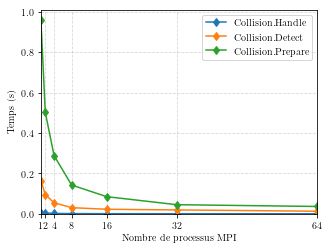

In [18]:
plot_times(strong_scaling_size)

### Efficacité

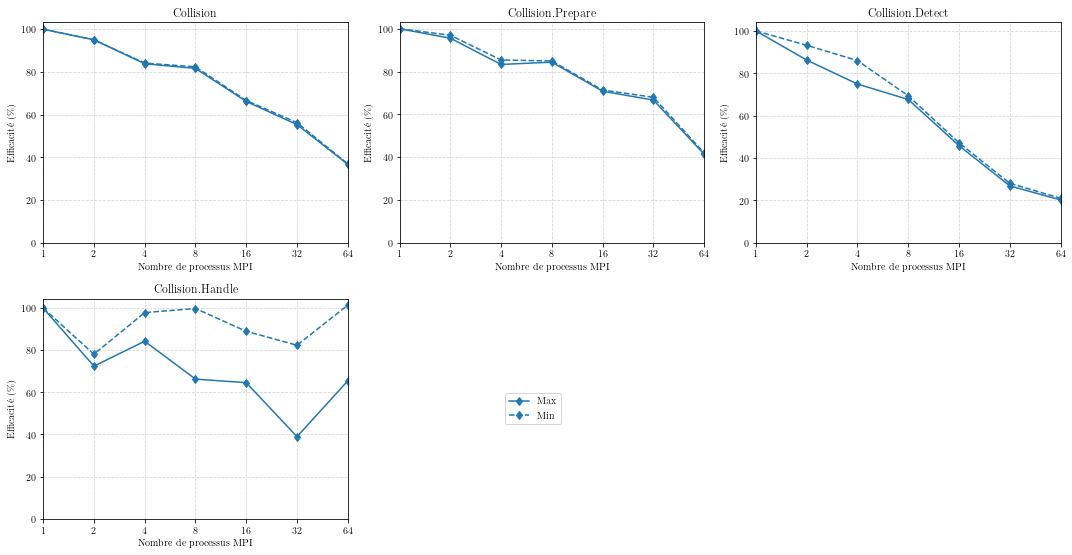

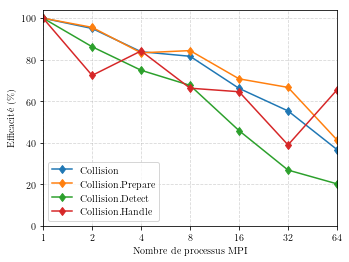

In [19]:
plot_efficiency( strong_scaling_size )